# Used Packages

In [1]:
import os
import shutil
import random

import pandas as pd
import spacy
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization

import matplotlib.pyplot as plt
import matplotlib

# Model Creation

In [2]:
PATH = 'data'
# set this parameter if you want to train another model
TRAIN_NEW_MODEL = True
NEW_MODEL_NAME = 'imdb2'

##  Dataset

In [3]:
# downloading the imdb dataset (if not already done)
# removing the unnecessary unsup folder because this is a supervised ml task
if not os.path.isdir('data'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True, cache_dir=PATH,
                                        cache_subdir='')

    shutil.rmtree('unsup')

In [4]:
# setting the directory for the training and test data
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

### Dataset Parameters

In [5]:
# setting model parameters
# autotune allows the automatic setting of the number of prefetched data ahead
# of time they are requested in the learning process
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
epochs = 1
seed = 42
init_lr = 3e-5

### Splitting Dataset

In [6]:
# training set 80 percent of all files with 20 left for validation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Model Training

In [7]:
if TRAIN_NEW_MODEL:
    # setting the bert encoder and preprocessor
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

    # generating the bert encoder and preprocess layer for the model
    # (save model error can be fixed by deleting temp folder)
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # function for building the classifiert model 
    # text input -> preprocessing -> encode -> droput -> dense 

    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

    # initialize classifier model
    classifier_model = build_classifier_model()

    # set loss and metric functions
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # create model hyperparameter optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    # early stopping 
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

    # compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # train the model
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

Epoch 1/5
1250/1250 [==============================] - 393s 304ms/step - loss: 0.4020 - binary_accuracy: 0.8008 - val_loss: 0.3255 - val_binary_accuracy: 0.8808
Epoch 2/5
1250/1250 [==============================] - 373s 299ms/step - loss: 0.2221 - binary_accuracy: 0.9169 - val_loss: 0.5659 - val_binary_accuracy: 0.8508


In [8]:
if TRAIN_NEW_MODEL:
    loss, accuracy = classifier_model.evaluate(test_ds)

1563/1563 [==============================] - 161s 103ms/step - loss: 0.5545 - binary_accuracy: 0.8536


In [9]:
if TRAIN_NEW_MODEL:
    saved_model_path = f'./models/{NEW_MODEL_NAME}_bert'
    classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./models/imdb2_bert\assets


INFO:tensorflow:Assets written to: ./models/imdb2_bert\assets


# Loading the model and working with it

In [10]:
if not TRAIN_NEW_MODEL:
    saved_model_path = f'models/{os.listdir("models")[0]}'
    model = tf.keras.models.load_model(saved_model_path, compile=False)
else: 
    model = classifier_model

## Get complete test data

In [11]:
test_data_unbatched = list(test_ds.unbatch().as_numpy_iterator())

## Select random pair

In [12]:
rand_ind = random.randint(0, len(test_data_unbatched))
rand_sen_label_pair = test_data_unbatched[rand_ind]
rand_sen_label_pair[0]

b'Warner Brothers social responsibility at its most ham-handed, with sermonizing every five minutes or so about how we\'re Americans, we don\'t run from trouble, we face up to our responsibilities. It also suggests that if you\'re willing to perjure yourself to protect your family from clearly deadly gangsters, you\'re un-American. Walter Huston, looking bored, is the frustrated DA, and the "average American family" includes such familiar faces as Sally Blane (looking a lot like her sister, Loretta Young) and Dickie Moore, as an allegedly adorable moppet. Both are regularly crowded out of the frame by Chic Sale, only 47 then but playing an octogenarian Civil War veteran, ponderously jumping and "amusingly" nipping at Prohibition hooch and moralizing about how we\'re Americans, dag nabbit. His St. Vitus Dance old-coot performance is tiresome schtick; it\'s like Walter Brennan based his entire career on it. William Wellman directs efficiently and quickly, much like his earlier "Public En

In [13]:
#function to classify a text given a model

def classify_text(model, text, parent_ind=None, child_ind=None):
    score = tf.sigmoid(model(tf.constant([text])))[0][0].numpy()
    pred_label = np.where(score > 0.5, 1, 0).item()

    if parent_ind or child_ind:
        return (score, pred_label, parent_ind, child_ind)
    else:
        return (score, pred_label)

## Predict random pair

In [14]:
org_text_pred = classify_text(model, rand_sen_label_pair[0])
print(f'Predicted Label: {org_text_pred[1]} \nPrediction Strength: {org_text_pred[0]} \nReal Label: {rand_sen_label_pair[1]}')

Predicted Label: 0 
Prediction Strength: 0.002830733545124531 
Real Label: 0


## Dependecy Parser

In [15]:
depend_parser = spacy.load('en_core_web_sm')

In [16]:
parsed_text = depend_parser(str(rand_sen_label_pair[0]))
sentence_spans = list(parsed_text.sents)[0]

In [17]:
spacy.displacy.render(sentence_spans, jupyter=True, options={"compact": True})

## Leave-n-out, strength calculation and linearization

In [18]:
# leave n out 
# go over all tokens, if a token has children, then for every token children pair
# return a text with both removed
new_texts = []
for token in parsed_text:
    if token.children:
        for child in token.children:
            new_text = []

            for item in parsed_text:
                if item.i == token.i or item.i == child.i:
                    pass
                else:
                    new_text.append(item.text)

            new_texts.append((" ".join(new_text), token.i, child.i))

In [19]:
# df of all created texts, with output strength, predicted label, parent index and child index
df = pd.DataFrame([
    classify_text(
        model, text_triple[0], text_triple[1], text_triple[2])
    for text_triple in new_texts],
    columns=['Output Strength',
             'Predicted Label',
             'Parent Index',
             'Child Index'])

df


,Output Strength,Predicted Label,Parent Index,Child Index
0,0.003570,0,1,0
1,0.002621,0,3,1
2,0.001735,0,3,2
3,0.002097,0,3,4
4,0.002443,0,3,10
...,...,...,...,...
208,0.001575,0,212,214
209,0.001575,0,212,217
210,0.001575,0,212,218
211,0.001575,0,214,216


In [20]:
# removes all texts which had the same output strength or better with the word pair removed
# thus not contributing to the prediction
df = df.drop(df.index[df['Output Strength'] >= org_text_pred[0]] )

In [21]:
# adds a new column Strength Difference which captures the difference of the new text prediction and the original
df['Strength Difference'] = org_text_pred[0] - df['Output Strength']


In [22]:
df_copy = df.copy()
df_copy[['Child Index', 'Parent Index']] = df[['Parent Index', 'Child Index']]
df = pd.concat([df, df_copy]).reset_index(drop=True)
df.drop(["Output Strength", "Predicted Label", "Child Index"], inplace=True, axis=1)
df = df.loc[df.groupby(['Parent Index'])["Strength Difference"].idxmax()]
df['Strength Difference'] = MinMaxScaler().fit_transform(df[['Strength Difference']])
df = df.sort_values(by=['Strength Difference'])
df.rename(columns={"Parent Index": "Token Index"}, inplace=True)
df

,Token Index,Strength Difference
213,8,0.000000
5,9,0.000000
208,1,0.113407
211,10,0.240674
212,11,0.441770
...,...,...
75,81,0.983176
303,102,0.988014
95,103,0.988014
272,67,1.000000


In [23]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue","lime"], gamma=0.75)

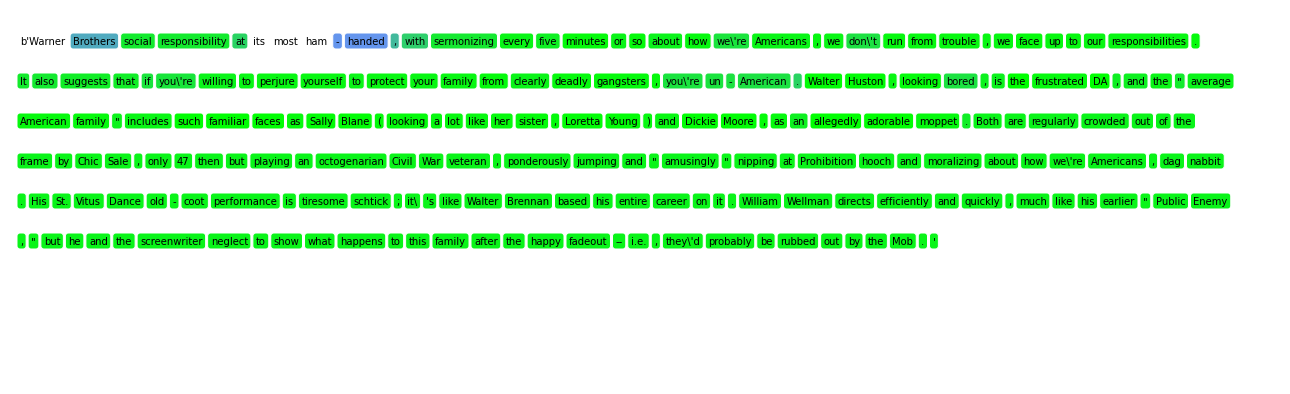

In [24]:
start_x = 20
start_y = 350
end = 1200
whitespace = 8

figure = plt.figure(figsize=(20, start_y/50))
rend = figure.canvas.get_renderer()

for token in parsed_text:
    if df.loc[df["Token Index"] == token.i, 'Strength Difference'].values.size > 0:
        col = cmap(df.loc[df["Token Index"] == token.i, 'Strength Difference'].values[0])
    else: 
        col = "white"
    bbox = dict(boxstyle="round,pad=0.3", fc=col, ec="white")

    # Check if word contains "foot", "feet", "foot." or "feet." or caps locked.
    # Depending what you are trying to achieve.
    txt = plt.text(start_x, start_y, str(token), bbox=bbox, transform=None)
    # Textbox width
    bb = txt.get_window_extent(renderer=rend)

    # Calculate where next word should be written
    start_x = bb.width + start_x + whitespace

    # Next line if end parameter in pixels have been crossed
    if start_x >= end:
        start_x = 20
        start_y -= 40

plt.axis("off")
plt.show()